## Created on Thr Aug 15 2024

## @author: Jeong-Woon, Park

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'CDH3'),
  Text(1, 0, 'ERBB2'),
  Text(2, 0, 'TYMS'),
  Text(3, 0, 'GREB1'),
  Text(4, 0, 'OSR1'),
  Text(5, 0, 'MYBL2'),
  Text(6, 0, 'FAM83D'),
  Text(7, 0, 'ESR1'),
  Text(8, 0, 'FOXC1'),
  Text(9, 0, 'NAT1')])

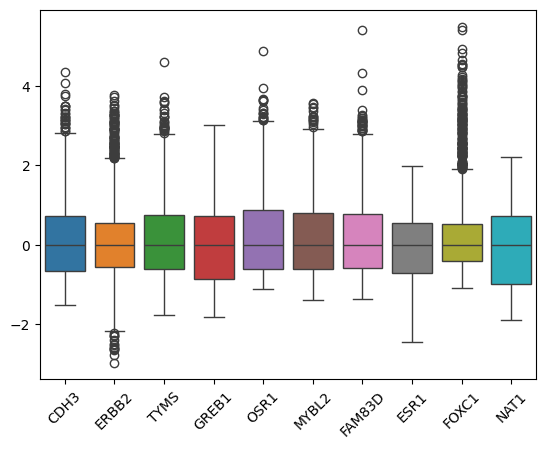

In [2]:
# Load X_train gene expression dataset.
X_train = pd.read_csv("X_train_feature_select.csv", sep = "\t", index_col = "Unnamed: 0")

# Feature distritubion after normalization (Train)
plt.rcdefaults()
sns.boxplot(X_train)
plt.xticks(rotation = 45)

In [3]:
# Load PAM50 subtype dataset.
target = pd.read_csv("GPL11154_PAM50.csv", sep = "\t", index_col = "geo_accession")
target.head()

,BRCA_Subtype_PAM50
geo_accession,
GSM2528079,Basal
GSM2528080,LumA
GSM2528081,LumB
GSM2528082,LumA
GSM2528084,Basal


In [4]:
# Load test PAM50 subtype dataset.
y_train = target.loc[X_train.index.tolist(), :]
y_train.head()

,BRCA_Subtype_PAM50
geo_accession,
GSM2528830,Her2
GSM2530511,LumA
GSM2529478,LumA
GSM2528452,LumA
GSM2531266,LumB


In [5]:
# Label Encoder
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoder = encoder.transform(y_train)

# Create series.
y_train = pd.Series(y_train_encoder, index = y_train.index)

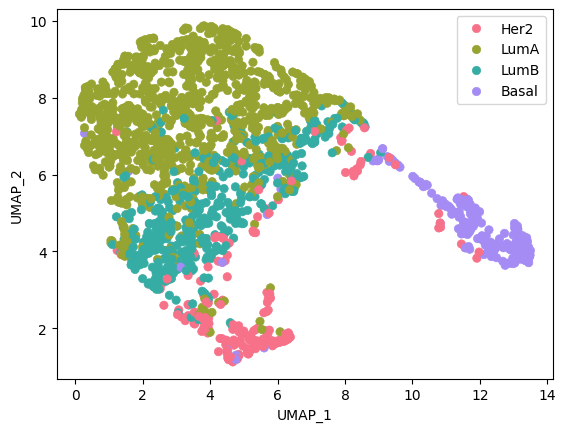

In [6]:
# Initialize UMAP
from umap import UMAP
plt.rcdefaults()

umap_2d = UMAP(n_components = 2, init = "random", random_state = 42)
proj_2d = umap_2d.fit_transform(X_train)
proj_2d = pd.DataFrame(proj_2d, columns = ["UMAP_1", "UMAP_2"])
proj_2d['PAM50'] = y_train.map({0: "Basal", 1: "Her2", 2: "LumA", 3: "LumB"}).values

# Plot using seaborn
sns.scatterplot(data = proj_2d, x = 'UMAP_1', y = 'UMAP_2', hue = 'PAM50', edgecolor = None, palette = "husl")
plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.legend(loc = 'best')
plt.show()

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, roc_auc_score, make_scorer, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_validate
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve

# Model fitting and prediction.
model = LogisticRegression(random_state = 42, penalty = "elasticnet", solver = "saga", 
                           max_iter = 10000, C = 1, l1_ratio = 0.7, class_weight = None)
model.fit(X_train, y_train)

LogisticRegression(C=1, l1_ratio=0.7, max_iter=10000, penalty='elasticnet',
                   random_state=42, solver='saga')

### Model performance using independent data (GSE81538)

In [8]:
# Load test gene expression dataset (GSE81538).
# The gene expression values were defined as log2(TPM + 1).
GSE81538_feature = pd.read_csv("GSE81538_feature_scale.csv", sep = "\t", index_col = "Unnamed: 0")
GSE81538_feature = GSE81538_feature.loc[:, X_train.columns.tolist()]
GSE81538_feature.shape

(383, 10)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'CDH3'),
  Text(1, 0, 'ERBB2'),
  Text(2, 0, 'TYMS'),
  Text(3, 0, 'GREB1'),
  Text(4, 0, 'OSR1'),
  Text(5, 0, 'MYBL2'),
  Text(6, 0, 'FAM83D'),
  Text(7, 0, 'ESR1'),
  Text(8, 0, 'FOXC1'),
  Text(9, 0, 'NAT1')])

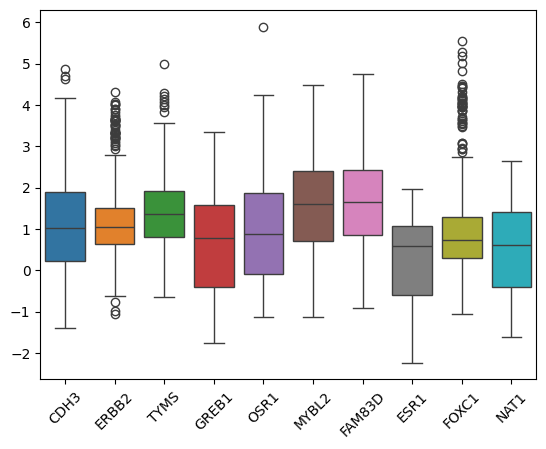

In [9]:
# Feature distritubion after normalization
plt.rcdefaults()
sns.boxplot(GSE81538_feature)
plt.xticks(rotation = 45)

In [10]:
# Load test PAM50 dataset.
GSE81538_target = pd.read_csv("GSE81538_PAM50.csv", sep = "\t", index_col = "geo_accession")
GSE81538_target_encoder = encoder.transform(GSE81538_target)
GSE81538_target = pd.Series(GSE81538_target_encoder, index = GSE81538_target.index)

In [11]:
# Prediction
y_pred = model.predict(GSE81538_feature)
y_pred_proba = model.predict_proba(GSE81538_feature)

In [12]:
# Classification report
print(classification_report(GSE81538_target, y_pred, target_names = ["Basal", "Her2", "LumA", "LumB"]))

              precision    recall  f1-score   support

       Basal       0.97      0.98      0.97        57
        Her2       0.85      0.95      0.90        65
        LumA       0.91      0.90      0.90       156
        LumB       0.84      0.78      0.81       105

    accuracy                           0.89       383
   macro avg       0.89      0.90      0.90       383
weighted avg       0.89      0.89      0.89       383



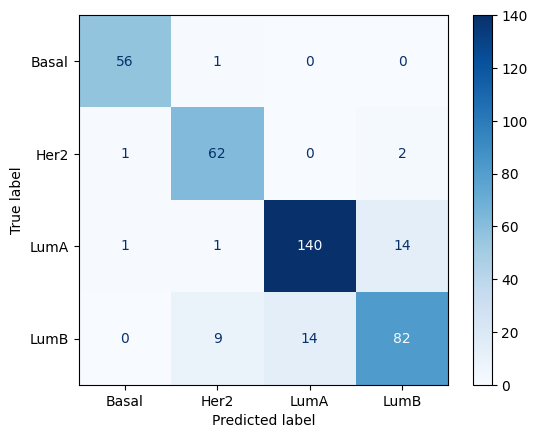

In [13]:
# Confusion matrix
plt.rcdefaults()
display = ConfusionMatrixDisplay.from_estimator(model, GSE81538_feature, GSE81538_target,
                                                display_labels = ["Basal", "Her2", "LumA", "LumB"],
                                                cmap = plt.cm.Blues, normalize = None)
plt.grid(False)
plt.show()

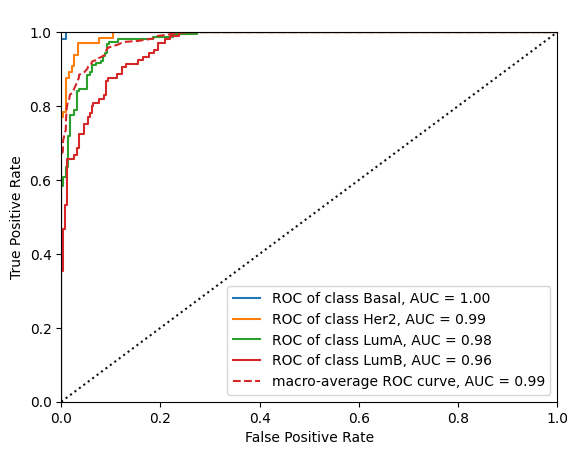

<Axes: title={'center': ' '}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [14]:
# ROC curve
plt.rcdefaults()
visualizer = ROCAUC(model, classes = ["Basal", "Her2", "LumA", "LumB"], macro = True, micro = False, title = " ")

visualizer.fit(X_train, y_train)        
visualizer.score(GSE81538_feature, GSE81538_target)       
visualizer.show()

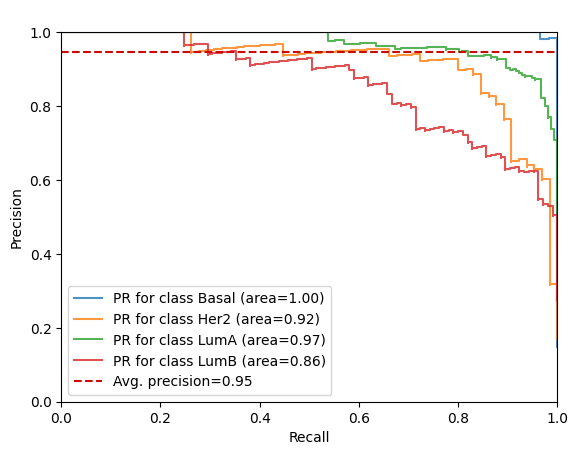

<Axes: title={'center': ' '}, xlabel='Recall', ylabel='Precision'>

In [15]:
# Precision-Recall curve
plt.rcdefaults()
visualizer = PrecisionRecallCurve(model, classes = ["Basal", "Her2", "LumA", "LumB"], micro = True, per_class = True, title = " ")

visualizer.fit(X_train, y_train)        
visualizer.score(GSE81538_feature, GSE81538_target)
visualizer.show()

In [16]:
# accuracy
accuracy_score(GSE81538_target, y_pred)

0.8877284595300261

In [17]:
# Macro average precision
precision_score(GSE81538_target, y_pred, average = "macro")

0.8901644782102303

In [18]:
# Macro average recall
recall_score(GSE81538_target, y_pred, average = "macro")

0.9036726431463273

In [19]:
# Macro average F1 score
f1_score(GSE81538_target, y_pred, average = "macro")

0.8958928369916425

In [20]:
# Macro average AUROC
roc_auc_score(GSE81538_target, y_pred_proba, multi_class = "ovr", average = "macro")

0.9846685221298623

### Model performance using independent data (GPL18573)

In [21]:
# Load test gene expression dataset (GPL18573).
# The gene expression values were defined as log2(TPM + 1).
GPL18573_feature = pd.read_csv("GPL18573_feature_scale.csv", sep = "\t", index_col = "Unnamed: 0")
GPL18573_feature = GPL18573_feature.loc[:, X_train.columns.tolist()]
GPL18573_feature.shape

(282, 10)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'CDH3'),
  Text(1, 0, 'ERBB2'),
  Text(2, 0, 'TYMS'),
  Text(3, 0, 'GREB1'),
  Text(4, 0, 'OSR1'),
  Text(5, 0, 'MYBL2'),
  Text(6, 0, 'FAM83D'),
  Text(7, 0, 'ESR1'),
  Text(8, 0, 'FOXC1'),
  Text(9, 0, 'NAT1')])

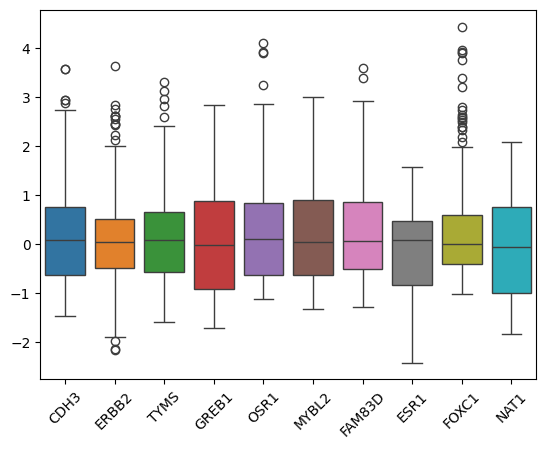

In [22]:
# Feature distritubion after normalization
plt.rcdefaults()
sns.boxplot(GPL18573_feature)
plt.xticks(rotation = 45)

In [23]:
# Load test PAM50 dataset.
GPL18573_target = pd.read_csv("GPL18573_PAM50.csv", sep = "\t", index_col = "geo_accession")
GPL18573_target_encoder = encoder.transform(GPL18573_target)
GPL18573_target = pd.Series(GPL18573_target_encoder, index = GPL18573_target.index)

In [24]:
# Prediction
y_pred = model.predict(GPL18573_feature)
y_pred_proba = model.predict_proba(GPL18573_feature)

In [25]:
# Classification report
print(classification_report(GPL18573_target, y_pred, target_names = ["Basal", "Her2", "LumA", "LumB"]))

              precision    recall  f1-score   support

       Basal       0.90      0.90      0.90        31
        Her2       0.88      0.72      0.79        32
        LumA       0.91      0.96      0.94       156
        LumB       0.87      0.84      0.85        63

    accuracy                           0.90       282
   macro avg       0.89      0.86      0.87       282
weighted avg       0.90      0.90      0.90       282



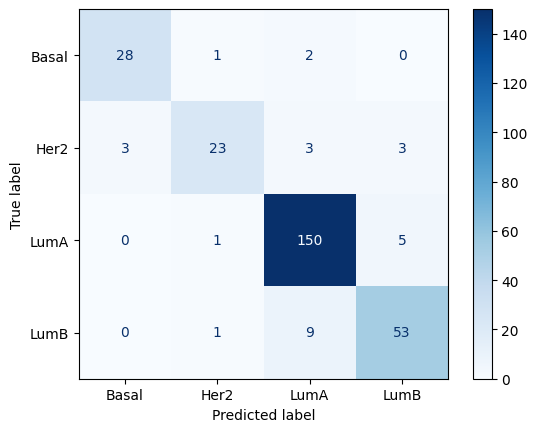

In [26]:
# Confusion matrix
plt.rcdefaults()
display = ConfusionMatrixDisplay.from_estimator(model, GPL18573_feature, GPL18573_target,
                                                display_labels = ["Basal", "Her2", "LumA", "LumB"],
                                                cmap = plt.cm.Blues, normalize = None)
plt.grid(False)
plt.show()

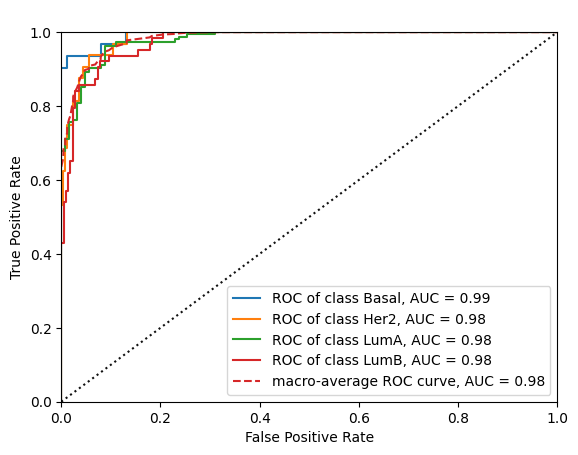

<Axes: title={'center': ' '}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [27]:
# ROC curve
plt.rcdefaults()
visualizer = ROCAUC(model, classes = ["Basal", "Her2", "LumA", "LumB"], macro = True, micro = False, title = " ", fontsize = 15)

visualizer.fit(X_train, y_train)        
visualizer.score(GPL18573_feature, GPL18573_target)
visualizer.show()

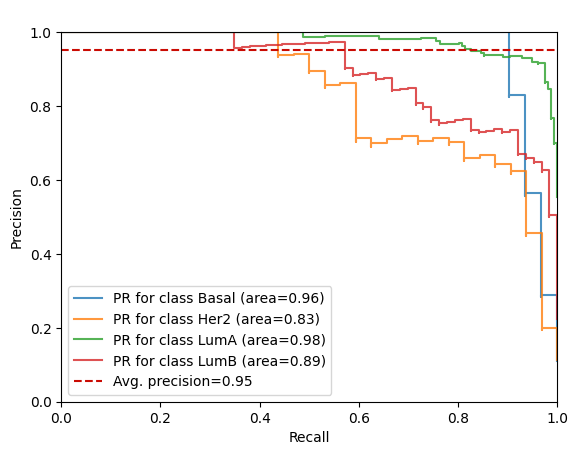

<Axes: title={'center': ' '}, xlabel='Recall', ylabel='Precision'>

In [28]:
# Precision-Recall curve
plt.rcdefaults()
visualizer = PrecisionRecallCurve(model, classes = ["Basal", "Her2", "LumA", "LumB"], micro = True, per_class = True, title = " ")

visualizer.fit(X_train, y_train)        
visualizer.score(GPL18573_feature, GPL18573_target)
visualizer.show()

In [29]:
# accuracy
accuracy_score(GPL18573_target, y_pred)

0.900709219858156

In [30]:
# Macro average precision
precision_score(GPL18573_target, y_pred, average = "macro")

0.8928319491062136

In [31]:
# Macro average recall
recall_score(GPL18573_target, y_pred, average = "macro")

0.856196027314979

In [32]:
# Macro average F1 score
f1_score(GPL18573_target, y_pred, average = "macro")

0.8721669911012236

In [33]:
# Macro average AUROC
roc_auc_score(GPL18573_target, y_pred_proba, multi_class = "ovr", average = "macro")

0.9830619598347544

### Model performance using independent data (GSE135298)

In [34]:
# Load test gene expression dataset (GSE135298).
# The gene expression values were defined as log2(TPM + 1).
GSE135298_feature = pd.read_csv("GSE135298_feature_scale.csv", sep = "\t", index_col = "Unnamed: 0")
GSE135298_feature = GSE135298_feature.loc[:, X_train.columns.tolist()]
GSE135298_feature.shape

(82, 10)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'CDH3'),
  Text(1, 0, 'ERBB2'),
  Text(2, 0, 'TYMS'),
  Text(3, 0, 'GREB1'),
  Text(4, 0, 'OSR1'),
  Text(5, 0, 'MYBL2'),
  Text(6, 0, 'FAM83D'),
  Text(7, 0, 'ESR1'),
  Text(8, 0, 'FOXC1'),
  Text(9, 0, 'NAT1')])

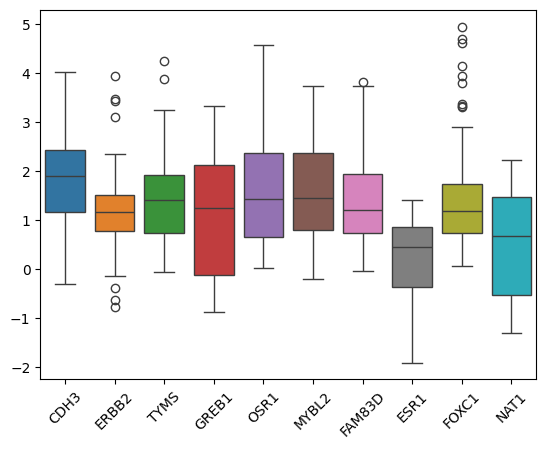

In [35]:
# Feature distritubion after normalization
plt.rcdefaults()
sns.boxplot(GSE135298_feature)
plt.xticks(rotation = 45)

In [36]:
# Load test PAM50 dataset.
GSE135298_target = pd.read_csv("GSE135298_PAM50.csv", sep = "\t", index_col = "geo_accession")
GSE135298_target_encoder = encoder.transform(GSE135298_target)
GSE135298_target = pd.Series(GSE135298_target_encoder, index = GSE135298_target.index)

In [37]:
# Prediction
y_pred = model.predict(GSE135298_feature)
y_pred_proba = model.predict_proba(GSE135298_feature)

In [38]:
# Classification report
print(classification_report(GSE135298_target, y_pred, target_names = ["Basal", "Her2", "LumA", "LumB"]))

              precision    recall  f1-score   support

       Basal       0.92      0.92      0.92        13
        Her2       0.55      0.86      0.67         7
        LumA       0.91      1.00      0.95        42
        LumB       1.00      0.60      0.75        20

    accuracy                           0.88        82
   macro avg       0.85      0.85      0.82        82
weighted avg       0.90      0.88      0.88        82



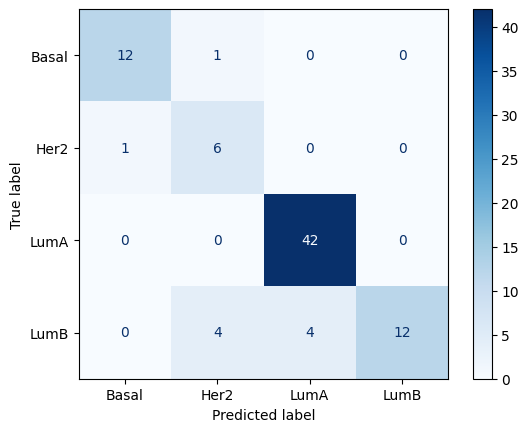

In [39]:
# Confusion matrix
plt.rcdefaults()
display = ConfusionMatrixDisplay.from_estimator(model, GSE135298_feature, GSE135298_target,
                                                display_labels = ["Basal", "Her2", "LumA", "LumB"],
                                                cmap = plt.cm.Blues, normalize = None)
plt.grid(False)
plt.show()

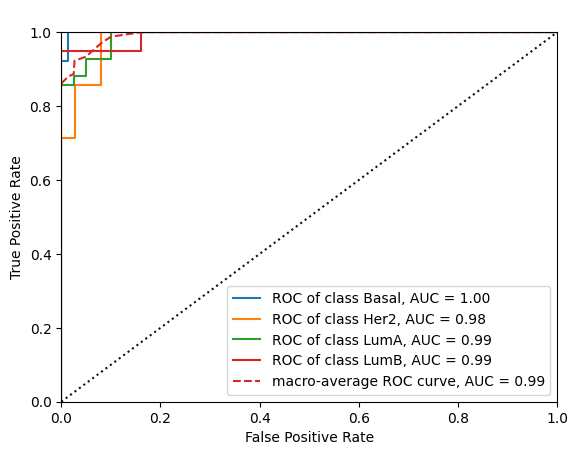

<Axes: title={'center': ' '}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [40]:
# ROC curve
plt.rcdefaults()
visualizer = ROCAUC(model, classes = ["Basal", "Her2", "LumA", "LumB"], macro = True, micro = False, title = " ", fontsize = 15)

visualizer.fit(X_train, y_train)        
visualizer.score(GSE135298_feature, GSE135298_target)
visualizer.show()

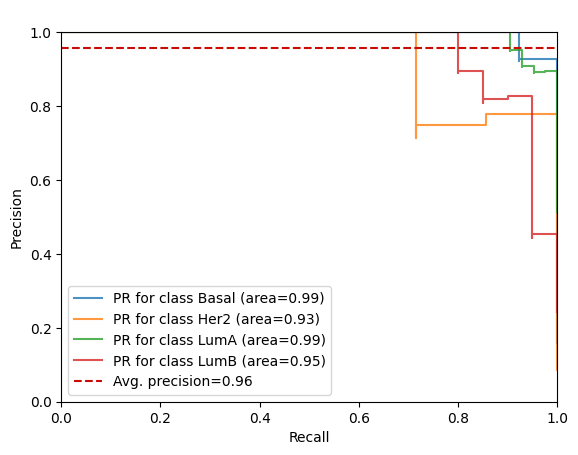

<Axes: title={'center': ' '}, xlabel='Recall', ylabel='Precision'>

In [41]:
# Precision-Recall curve
plt.rcdefaults()
visualizer = PrecisionRecallCurve(model, classes = ["Basal", "Her2", "LumA", "LumB"], micro = True, per_class = True, title = " ")

visualizer.fit(X_train, y_train)        
visualizer.score(GSE135298_feature, GSE135298_target)
visualizer.show()

In [42]:
# accuracy
accuracy_score(GSE135298_target, y_pred)

0.8780487804878049

In [43]:
# Macro average precision
precision_score(GSE135298_target, y_pred, average = "macro")

0.8453937366980845

In [44]:
# Macro average recall
recall_score(GSE135298_target, y_pred, average = "macro")

0.845054945054945

In [45]:
# Macro average F1 score
f1_score(GSE135298_target, y_pred, average = "macro")

0.8235722610722611

In [46]:
# Macro average AUROC
roc_auc_score(GSE135298_target, y_pred_proba, multi_class = "ovr", average = "macro")

0.9913658784530104